# Brain Topographic Each song

In [2]:
import os
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
import mne
import matplotlib.pyplot as plt

# Define directories
in_dir = r'D:\Imputed_file'  # EEG data folder
miscDir = r'C:\Users\napat\Documents\GitHub\BCC_2024\Code\Misc'  

# Define the range of songs (21 to 30)
song_indices = range(21, 31)

# Define channel names manually based on your EEG setup
channel_names = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz'
]

# Load the standard 10-20 montage
standard_montage = mne.channels.make_standard_montage('standard_1020')


# Apply DC correction
def median_dc_correct_all_trials(data):
    median_across_trials = np.median(data, axis=0)  # Shape: (samples, channels)
    corrected_data = data - median_across_trials  # Broadcasting over trials
    return corrected_data


Loading song21_Imputed.mat...
Applied DC correction for song 21.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


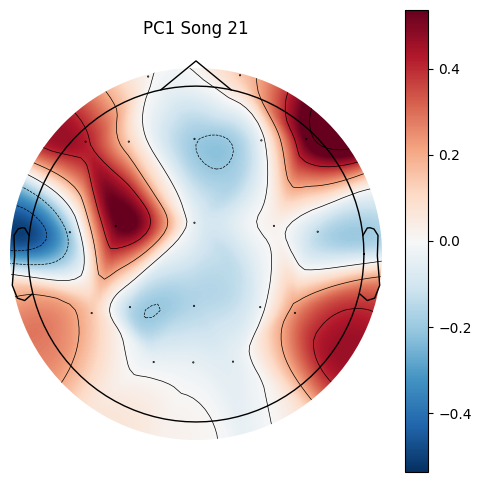

Loading song22_Imputed.mat...
Applied DC correction for song 22.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


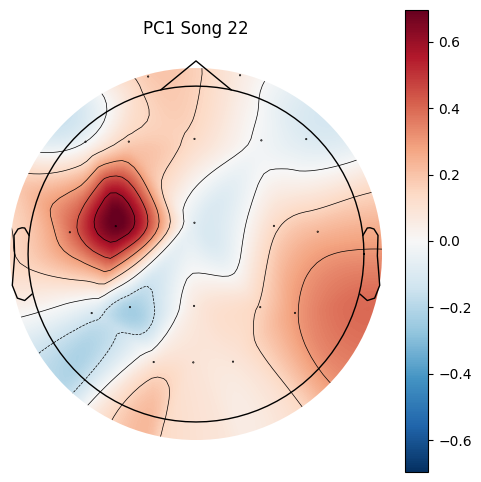

Loading song23_Imputed.mat...
Applied DC correction for song 23.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


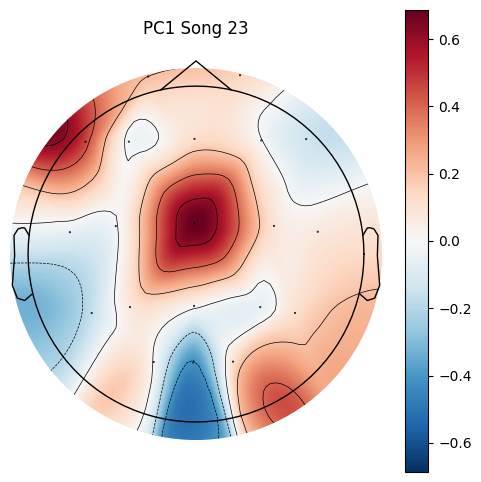

Loading song24_Imputed.mat...
Applied DC correction for song 24.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


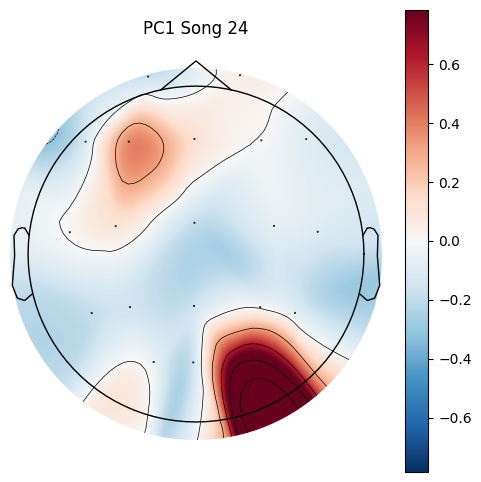

Loading song25_Imputed.mat...
Applied DC correction for song 25.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


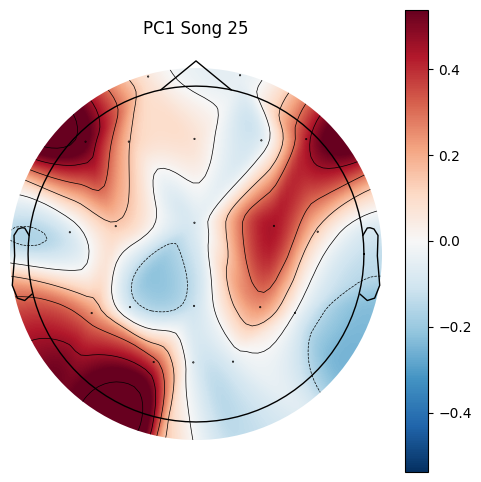

Loading song26_Imputed.mat...
Applied DC correction for song 26.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


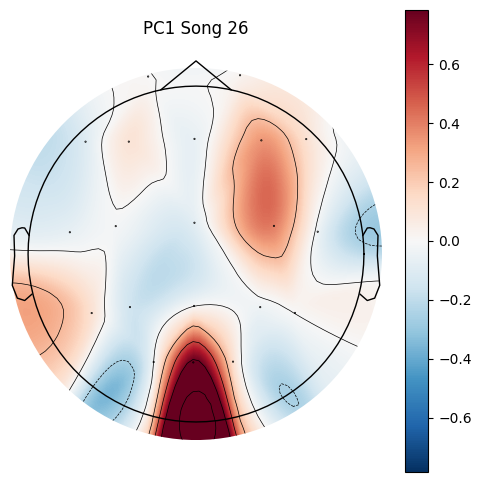

Loading song27_Imputed.mat...
Applied DC correction for song 27.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


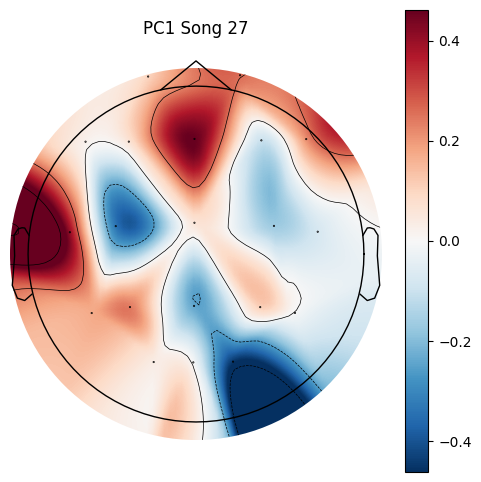

Loading song28_Imputed.mat...
Applied DC correction for song 28.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


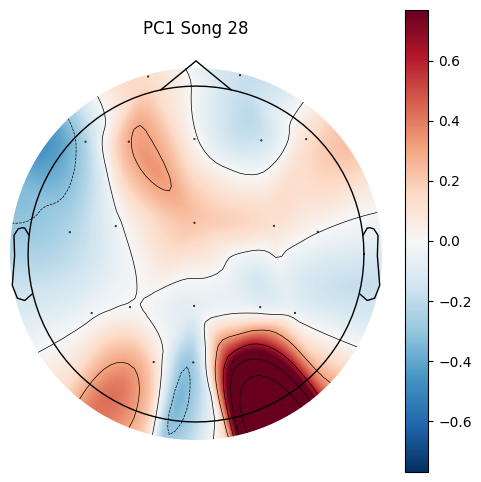

Loading song29_Imputed.mat...
Applied DC correction for song 29.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


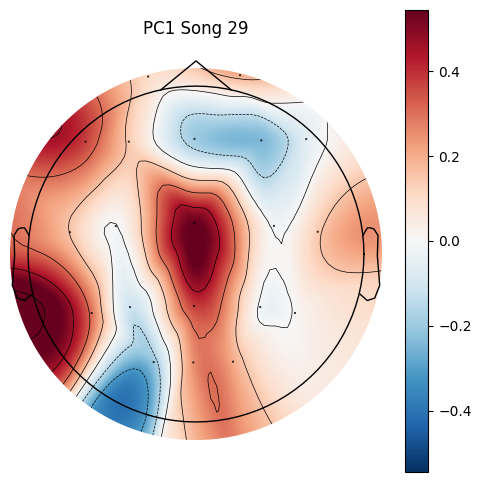

Loading song30_Imputed.mat...
Applied DC correction for song 30.


C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:29: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_32500\160312880.py:32: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


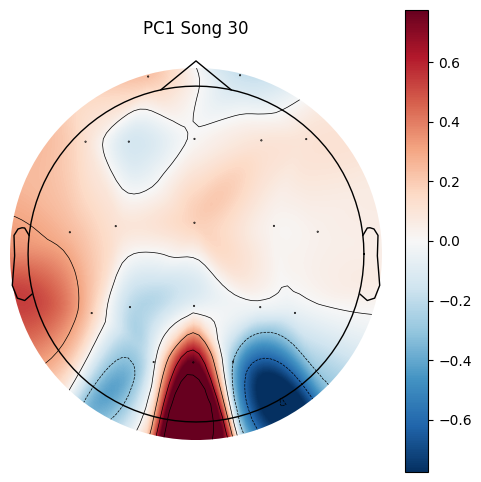

In [4]:

# Loop over all songs (21 to 30)
for song_idx in song_indices:
    currFn = f'song{song_idx}_Imputed.mat'

    # Load the .mat file
    print(f'Loading {currFn}...')
    mat_file = sio.loadmat(os.path.join(in_dir, currFn))

    # Extract the data
    subs = mat_file[f'subs{song_idx}']
    data = mat_file[f'data{song_idx}']  # Shape: (trials, samples, channels)

    # Verify the number of channels matches
    if len(channel_names) != data.shape[2]:
        raise ValueError(f"Number of channel names ({len(channel_names)}) does not match number of data channels ({data.shape[2]}).")

    # Create the Info object
    fs = mat_file['fs'][0, 0]  # Extract sampling frequency
    info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')
    info.set_montage(standard_montage)


    tempX_dc = median_dc_correct_all_trials(data)
    print(f"Applied DC correction for song {song_idx}.")

    # Define epoch parameters
    sec_start = 15
    epochLenSec = 4 * 60  # 4 minutes
    epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch

    # Calculate start and end indices
    start_idx = sec_start * fs  # 15 seconds into the recording
    end_idx = start_idx + epoch_len_samp

    # Verify that end_idx does not exceed the total number of samples
    total_samples = tempX_dc.shape[1]
    if end_idx > total_samples:
        raise ValueError(f"End index ({end_idx}) exceeds total samples ({total_samples}).")

    # Extract epoch
    tempX_epoch = tempX_dc[:, start_idx:end_idx, :]  # Shape: (trials, samples, channels)

    # Average over time for each trial
    trial_mean = tempX_epoch.mean(axis=1)  # Shape: (trials, channels)

    # Perform PCA
    pca = PCA(n_components=1)
    pca.fit(trial_mean)
    pc1 = pca.components_[0]  # Shape: (channels,)
    explained_variance = pca.explained_variance_ratio_[0]

    # Create an Evoked-like object for plotting
    evoked = mne.EvokedArray(pc1[:, np.newaxis], info)

    # Plot the topomap
    fig, ax = plt.subplots(figsize=(6, 6))
    im, cm_map = mne.viz.plot_topomap(pc1, evoked.info, axes=ax, show=False, cmap='RdBu_r')
    plt.colorbar(im, ax=ax)
    ax.set_title(f'PC1 Song {song_idx}')
    plt.show()

    output_dir = r'C:\Users\napat\Documents\GitHub\BCC_2024\Code\code_testing\Graph\EEG'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_file = os.path.join(output_dir, f'PC1_Topomap_Song_{song_idx}.png')

    fig.savefig(output_file, dpi=300)